In [3]:
#Udai Nagpal, 
# -----------Part 5(iv)------------
import numpy as np
import math
from numpy import linalg as LA

#Element by element sigmoid of column vector
def sigmoid(x):
    output = np.zeros((x.shape[0], 1))
    for i in range(x.shape[0]):
        output[i,0] = 1.0/(1.0+math.exp(-x[i,0]))
    return output

#Scalar sigmoid
def sigmoid_deriv_scalar(x):
    sig_x = 1.0/(1.0+math.exp(-x))
    return sig_x * (1-sig_x)

def sigmoid_scalar(x):
    return 1.0/(1.0+math.exp(-x))

#Element by element sigmoid derivative of column vector
def sigmoid_deriv(x):
    output = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        temp_arr = np.zeros((1,1))
        temp_arr[0][0] = x[i,0]
        output[i,0] = sigmoid(temp_arr) * (1 - sigmoid(temp_arr))
    return output
y = np.array([[1],[2],[-1],[-3]])
print(sigmoid(y))
print(sigmoid_deriv(y))

[[0.73105858]
 [0.88079708]
 [0.26894142]
 [0.04742587]]
[[0.19661193]
 [0.10499359]
 [0.19661193]
 [0.04517666]]


In [4]:
def stochastic_gradient_descent (input_data, output_data, inter_layer_sizes, convergence_cutoff=0.00001, max_iterations=50, minibatch_size=25, learning_rate=0.2):
    layer_sizes = [len(input_data[0])] + inter_layer_sizes + [len(output_data[0])]
    num_layers = len(layer_sizes)
    #Random Initialization
    W = [np.random.uniform(low=-2.0, high=2.0, size=(layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
    dW = [[np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)] for j in range(minibatch_size)]
    b = [np.random.uniform(low=-2.0, high=2.0, size=(layer_sizes[i+1],)) for i in range(num_layers-1)]
    db = [[np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)] for j in range(minibatch_size)]
    abs_adjustments_W = [100*np.ones((layer_sizes[i],layer_sizes[i+1])) for i in range(num_layers-1)]
    abs_adjustments_b = [100*np.ones((layer_sizes[i+1],)) for i in range(len(layer_sizes)-1)]
    #print('W:' + str(W))
    #print('b:' + str(b))
    elapsed_iterations = 0
    max_adjustment_W, max_adjustment_b = 100, 100
    while(elapsed_iterations<max_iterations and max_adjustment_W>=convergence_cutoff and max_adjustment_b>=convergence_cutoff):
        stochastic_sample = np.random.choice(a=len(output_data),size=minibatch_size, replace=False)
        sample_inputs = [input_data[i] for i in stochastic_sample]
        sample_outputs = [output_data[i] for i in stochastic_sample]
        dW_sum = [np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
        db_sum = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
        sample_predictions = []
        running_cost = 0
        for sample in range(len(sample_outputs)):
            x = sample_inputs[sample]
            y = sample_outputs[sample]
            #print('sample input: ' + str(x))
            #print('sample output: ' + str(y))
            saved_forward_pass = [x]
            layer_input = x
            #Forward Pass
            for layer in range(num_layers-1):
                layer_output = np.add(np.dot(np.transpose(W[layer]), layer_input),b[layer])
                out_dim = layer_output.shape[0]
                layer_input = sigmoid(np.reshape(layer_output, (out_dim,1)))
                layer_input = np.hstack(layer_input)
                saved_forward_pass.append(layer_input)
            sample_prediction = np.array(saved_forward_pass[-1:])
            running_cost += LA.norm(np.subtract(sample_prediction, np.array(y)))**2.0
            #BACKPROPAGATION
            deltas = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
            for output_component in range(len(deltas[num_layers-2])):
                deltas[num_layers-2][output_component] = -1.0 * (y[output_component]-saved_forward_pass[-1][output_component])*saved_forward_pass[-1][output_component]*(1-saved_forward_pass[-1][output_component])
            #Backpropagating Deltas
            for layer in range(num_layers-3, -1, -1):
                for neuron_ind in range(len(saved_forward_pass[layer+1])):
                    sigmoid_val = saved_forward_pass[layer+1][neuron_ind]
                    partial_sigmoid = (sigmoid_val) * (1 - sigmoid_val)
                    corr_weights = np.array(W[layer+1][neuron_ind,:])
                    corr_deltas = np.array(deltas[layer+1])
                    deltas[layer][neuron_ind] = partial_sigmoid * np.dot(corr_weights, corr_deltas)
            #Computing gradient of cost function w.r.t. W and b
            for layer in range(num_layers-1):
                for j in range(len(saved_forward_pass[layer+1])):
                    for i in range(len(saved_forward_pass[layer])):
                        dW[sample][layer][i,j] = deltas[layer][j] * saved_forward_pass[layer][i]
                    db[sample][layer][j] = deltas[layer][j]
            for i in range(len(dW_sum)):
                dW_sum[i] = np.add(dW_sum[i], dW[sample][i])
            #print(dW[sample])
            #dW_sum = np.add(dW_sum, dW[sample])
            db_sum = np.add(db_sum,db[sample])
            #print('deltas: ' + str(deltas))
            #print('dW: ' + str(dW))
            #print('db: ' + str(db))
        print("Cost Function: " + str(running_cost/(2.0*minibatch_size)))
        #print('dW sum: ' + str(dW_sum))
        db_avg = db_sum / minibatch_size
        dW_avg = [dWi/minibatch_size for dWi in dW_sum]
        #Updating Weight Parameters and Checking for Convergence
        max_adjustment_W = 0
        max_adjustment_b = 0
        for layer in range(num_layers-1):
            W[layer] = W[layer] - learning_rate * dW_avg[layer]
            b[layer] = b[layer] - learning_rate * db_avg[layer]
            adj_W = np.absolute(learning_rate * dW_avg[layer])
            adj_b = np.absolute(learning_rate * db_avg[layer])
            if (np.amax(adj_W) > max_adjustment_W):
                max_adjustment_W = np.amax(adj_W)
            if (np.amax(adj_b) > max_adjustment_b):
                max_adjustment_b = np.amax(adj_b)
        #print('Updated W: ' + str(W))
        #print('Updated b: ' + str(b))
        elapsed_iterations += 1
        #print(elapsed_iterations)
    #Final Output Predictions from Trained Model  
    final_pred_outputs = []
    for input_point in input_data:
        forward_pass = [input_point]
        layer_input = input_point
        for layer in range(num_layers-1):
            layer_output = np.add(np.dot(np.transpose(W[layer]), layer_input),b[layer])
            #print(layer_output)
            out_dim = layer_output.shape[0]
            layer_input = sigmoid(np.reshape(layer_output, (out_dim,1)))
            layer_input = np.hstack(layer_input)
            forward_pass.append(layer_input)
        #print(forward_pass)
        final_pred_outputs.append(forward_pass[-1:])
    final_pred_outputs = [output.tolist() for out_list in final_pred_outputs for output in out_list]
    print("Final W: " + str(W))
    print("Final b: " + str(b))
    #print("Actual Outputs: " + str(output_data))
    #print("Predicted Outputs: " + str(final_pred_outputs))
    print("Total Elapsed Iterations: " + str(elapsed_iterations))

In [5]:
#TEST OF STOCHASTIC GRADIENT DESCENT: COST FUNCTION IS INDEED MINIMIZED
my_input = [i.tolist() for i in np.random.uniform(size=(100,2))]
#print(my_input)
my_output = []
for j in range(len(my_input)):
    my_output.append([sigmoid_scalar(1*my_input[j][0] +2*my_input[j][1] - 1), sigmoid_scalar(1.2*my_input[j][0] +1.7*my_input[j][1] - 1.3)])
my_output = np.array(my_output)
#print(my_output)
stochastic_gradient_descent(my_input, my_output, [2,2])

Cost Function: 0.07596979565973572
Cost Function: 0.07161246866868085
Cost Function: 0.0638563735598339
Cost Function: 0.07452103619383495
Cost Function: 0.06872783611484146
Cost Function: 0.06598663431643255
Cost Function: 0.07150003213596266
Cost Function: 0.06406329303206673
Cost Function: 0.05881483273224248
Cost Function: 0.05971981424075594
Cost Function: 0.061956933189715485
Cost Function: 0.05687901860424522
Cost Function: 0.059762151995902506
Cost Function: 0.05555485243128921
Cost Function: 0.05723868796537282
Cost Function: 0.05526236846481139
Cost Function: 0.05709173998391883
Cost Function: 0.04898437948131638
Cost Function: 0.05390401135794689
Cost Function: 0.05350927790778833
Cost Function: 0.04788890137833634
Cost Function: 0.047104053198132864
Cost Function: 0.04325387373411611
Cost Function: 0.04787389067686995
Cost Function: 0.048527983831741714
Cost Function: 0.051153145092108894
Cost Function: 0.047629983525173544
Cost Function: 0.04602641693749382
Cost Function: 

In [6]:
def adam (input_data, output_data, inter_layer_sizes, convergence_cutoff=0.000001, max_iterations=3000, minibatch_size=100, learning_rate=0.0015):
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 10**(-8.0)
    layer_sizes = [len(input_data[0])] + inter_layer_sizes + [len(output_data[0])]
    num_layers = len(layer_sizes)
    #Random Initialization
    W = [np.random.uniform(low=-1.0, high=1.0, size=(layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
    dW = [[np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)] for j in range(minibatch_size)]
    b = [np.random.uniform(low=-1.0, high=1.0, size=(layer_sizes[i+1],)) for i in range(num_layers-1)]
    db = [[np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)] for j in range(minibatch_size)]
    m = [np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
    v = [np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
    m_b = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
    v_b = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
    abs_adjustments_W = [100*np.ones((layer_sizes[i],layer_sizes[i+1])) for i in range(num_layers-1)]
    abs_adjustments_b = [100*np.ones((layer_sizes[i+1],)) for i in range(len(layer_sizes)-1)]
    #print('W:' + str(W))
    #print('b:' + str(b))
    elapsed_iterations = 0
    max_adjustment_W, max_adjustment_b = 100, 100
    while(elapsed_iterations<max_iterations and max_adjustment_W>=convergence_cutoff and max_adjustment_b>=convergence_cutoff):
        stochastic_sample = np.random.choice(a=len(output_data),size=minibatch_size, replace=False)
        sample_inputs = [input_data[i] for i in stochastic_sample]
        sample_outputs = [output_data[i] for i in stochastic_sample]
        dW_sum = [np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
        db_sum = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
        sample_predictions = []
        running_cost = 0
        for sample in range(len(sample_outputs)):
            x = sample_inputs[sample]
            y = sample_outputs[sample]
            #print('sample input: ' + str(x))
            #print('sample output: ' + str(y))
            saved_forward_pass = [x]
            layer_input = x
            #Forward Pass
            for layer in range(num_layers-1):
                layer_output = np.add(np.dot(np.transpose(W[layer]), layer_input),b[layer])
                out_dim = layer_output.shape[0]
                layer_input = sigmoid(np.reshape(layer_output, (out_dim,1)))
                layer_input = np.hstack(layer_input)
                saved_forward_pass.append(layer_input)
            sample_prediction = np.array(saved_forward_pass[-1:])
            running_cost += LA.norm(np.subtract(sample_prediction, np.array(y)))**2.0
            #BACKPROPAGATION
            deltas = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
            for output_component in range(len(deltas[num_layers-2])):
                deltas[num_layers-2][output_component] = -1.0 * (y[output_component]-saved_forward_pass[-1][output_component])*saved_forward_pass[-1][output_component]*(1-saved_forward_pass[-1][output_component])
            #Backpropagating Deltas
            for layer in range(num_layers-3, -1, -1):
                for neuron_ind in range(len(saved_forward_pass[layer+1])):
                    sigmoid_val = saved_forward_pass[layer+1][neuron_ind]
                    partial_sigmoid = (sigmoid_val) * (1 - sigmoid_val)
                    corr_weights = np.array(W[layer+1][neuron_ind,:])
                    corr_deltas = np.array(deltas[layer+1])
                    deltas[layer][neuron_ind] = partial_sigmoid * np.dot(corr_weights, corr_deltas)
            #Computing gradient of cost function w.r.t. W and b
            for layer in range(num_layers-1):
                for j in range(len(saved_forward_pass[layer+1])):
                    for i in range(len(saved_forward_pass[layer])):
                        dW[sample][layer][i,j] = deltas[layer][j] * saved_forward_pass[layer][i]
                    db[sample][layer][j] = deltas[layer][j]
            for i in range(len(dW_sum)):
                dW_sum[i] = np.add(dW_sum[i], dW[sample][i])
            #print(dW[sample])
            #dW_sum = np.add(dW_sum, dW[sample])
            db_sum = np.add(db_sum,db[sample])
            #print('deltas: ' + str(deltas))
            #print('dW: ' + str(dW))
            #print('db: ' + str(db))
        print("Cost Function: " + str(running_cost/(2.0*minibatch_size)))
        #print('dW sum: ' + str(dW_sum))
        db_avg = db_sum / minibatch_size
        dW_avg = [dWi/minibatch_size for dWi in dW_sum]
        #Updating Weight Parameters and Checking for Convergence
        max_adjustment_W = 0
        max_adjustment_b = 0
        for layer in range(num_layers-1):
            m[layer] = beta_1 * m[layer] + (1-beta_1)*dW_avg[layer]
            v[layer] = beta_2 * v[layer] + (1-beta_2)*np.square(dW_avg[layer])
            eps_matrix = epsilon * np.ones((np.shape(dW_avg[layer])[0], np.shape(dW_avg[layer])[1]))
            W[layer] = W[layer] - learning_rate * np.divide(m[layer], np.add(np.sqrt(v[layer]), eps_matrix))
            m_b[layer] = beta_1 * m_b[layer] + (1-beta_1)*db_avg[layer]
            v_b[layer] = beta_2 * v_b[layer] + (1-beta_2)*np.square(db_avg[layer])
            eps_matrix_b = epsilon * np.ones((np.shape(db_avg[layer])[0]))
            b[layer] = b[layer] - learning_rate * np.divide(m_b[layer], np.add(np.sqrt(v_b[layer]), eps_matrix_b))
            #b[layer] = b[layer] - learning_rate * db_avg[layer]
            adj_W = np.absolute(learning_rate * np.divide(m[layer], np.add(np.sqrt(v[layer]), eps_matrix)))
            adj_b = np.absolute(learning_rate * np.divide(m_b[layer], np.add(np.sqrt(v_b[layer]), eps_matrix_b)))
            if (np.amax(adj_W) > max_adjustment_W):
                max_adjustment_W = np.amax(adj_W)
            if (np.amax(adj_b) > max_adjustment_b):
                max_adjustment_b = np.amax(adj_b)
        #print('Updated W: ' + str(W))
        #print('Updated b: ' + str(b))
        elapsed_iterations += 1
        #print(elapsed_iterations)
    #Final Output Predictions from Trained Model  
    final_pred_outputs = []
    for input_point in input_data:
        forward_pass = [input_point]
        layer_input = input_point
        for layer in range(num_layers-1):
            layer_output = np.add(np.dot(np.transpose(W[layer]), layer_input),b[layer])
            #print(layer_output)
            out_dim = layer_output.shape[0]
            layer_input = sigmoid(np.reshape(layer_output, (out_dim,1)))
            layer_input = np.hstack(layer_input)
            forward_pass.append(layer_input)
        #print(forward_pass)
        final_pred_outputs.append(forward_pass[-1:])
    final_pred_outputs = [output.tolist() for out_list in final_pred_outputs for output in out_list]
    print("Final W: " + str(W))
    print("Final b: " + str(b))
    #print("Actual Outputs: " + str(output_data))
    #print("Predicted Outputs: " + str(final_pred_outputs))
    print("Total Elapsed Iterations: " + str(elapsed_iterations))
    return final_pred_outputs

#Testing adam
adam(input_data=my_input, output_data = my_output, inter_layer_sizes=[2,2],max_iterations=50, minibatch_size=15)

Cost Function: 0.0921519902383656
Cost Function: 0.06972380184353762
Cost Function: 0.07393973554741144
Cost Function: 0.07768499830148336
Cost Function: 0.07699349807600038
Cost Function: 0.07469674788028825
Cost Function: 0.08618411618370343
Cost Function: 0.08256895360995137
Cost Function: 0.08251197902822788
Cost Function: 0.05302920295162518
Cost Function: 0.039676674182014114
Cost Function: 0.08243997252896854
Cost Function: 0.0540464247202084
Cost Function: 0.07372365165458926
Cost Function: 0.07129546240148678
Cost Function: 0.07692161557371133
Cost Function: 0.04815704256150972
Cost Function: 0.044000872285543245
Cost Function: 0.06494551782185602
Cost Function: 0.0437302672130728
Cost Function: 0.039977200166502753
Cost Function: 0.03236940313293362
Cost Function: 0.05483107361645156
Cost Function: 0.042475565735589436
Cost Function: 0.027892655024739237
Cost Function: 0.039482920029457365
Cost Function: 0.05213495236360644
Cost Function: 0.032877099248495016
Cost Function: 0

[[0.6114737263954781, 0.4146820506282792],
 [0.6095301307856859, 0.41543785716790393],
 [0.610809100357292, 0.4149347448696997],
 [0.6113794453003132, 0.4147471887410024],
 [0.6109338491384803, 0.41492951296586844],
 [0.6110284666171305, 0.41485090865410046],
 [0.6106356013066424, 0.41503874639973853],
 [0.611628112062632, 0.41461344734306954],
 [0.6112025266129121, 0.41482090494265694],
 [0.6111531159997169, 0.4148204299657112],
 [0.6120871596806491, 0.4144147017959127],
 [0.6125485563511646, 0.41423682168082127],
 [0.6105644191926144, 0.41505203053795015],
 [0.6127206439728448, 0.4141693033328355],
 [0.6125603616951472, 0.4142419441934433],
 [0.6103476687410909, 0.41513643296381725],
 [0.6091468085610294, 0.415574526243988],
 [0.6113174527381378, 0.4147325910391071],
 [0.609532116698143, 0.415430887592693],
 [0.6102231835117481, 0.41516886508436557],
 [0.6111733764205675, 0.4148197922340345],
 [0.6127654975009368, 0.4141258094427866],
 [0.6105435834882232, 0.4150590649062059],
 [0.61

In [7]:
#--------------PART 5(v)----------------
#Gathering Data & Learning Lincoln Image
%matplotlib inline
from scipy.io import loadmat
from matplotlib import pyplot
x = loadmat('hw2_data.mat')
X1 = x['X1']
Y1 = x['Y1']
X2 = x['X2']
Y2 = x['Y2']
img_2 = Y2.reshape(133, 140, 3)/np.amax(Y2)
img_1 = Y1.reshape(100, 76) 
#pyplot.imshow(X=img_1, cmap='gray')
#pyplot.imshow(X=img_2)
Y1_norm = np.divide(Y1, np.amax(Y1))

#Training Lincoln Model
Y1_pred = adam(input_data = X1, output_data = Y1_norm, inter_layer_sizes=[128,256], max_iterations=10, minibatch_size=128, learning_rate=0.001)

Cost Function: 0.11216364074386566
Cost Function: 0.09929663998679333
Cost Function: 0.08298649985010358
Cost Function: 0.10202279012067829
Cost Function: 0.06054810435694754
Cost Function: 0.09547319040598697
Cost Function: 0.07954230589375912
Cost Function: 0.07456052834802566
Cost Function: 0.06874013379503889
Cost Function: 0.06948561852474636
Final W: [array([[ 6.23416584e-01, -4.91676194e-01, -7.51533204e-01,
         9.44512420e-01,  2.07870636e-01, -9.65905835e-01,
        -9.62859188e-01,  1.98745371e-01,  4.99745175e-01,
         4.64735587e-01, -8.83988476e-01, -9.11931840e-01,
        -2.22648191e-01, -5.08862498e-01, -4.88941572e-01,
         7.49986235e-01,  9.61204190e-03, -1.85409816e-01,
         7.70788298e-01,  6.78207943e-01,  8.34525707e-01,
        -6.59776410e-01,  7.46594385e-01, -3.97695223e-01,
        -6.29716609e-01,  3.08086085e-03,  8.13318839e-01,
         6.08787212e-02, -6.31696216e-01,  9.94036764e-01,
        -4.02945864e-01, -5.08423266e-01,  4.63400

[[0.57740587]
 [0.58577406]
 [0.60251045]
 ...
 [0.21757323]
 [0.19246861]
 [0.17573221]]


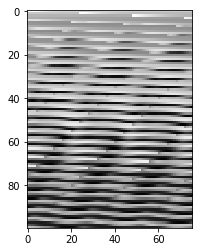

In [9]:
#Showing Lincoln Results
print(Y1_norm)
#print(Y1_pred)
#print(Y1_pred)
pyplot.imshow(X=np.array(Y1_pred).reshape(100,76), cmap='gray')

In [10]:
#Training Flower Model
img_2 = Y2.reshape(133, 140, 3)/np.amax(Y2)
Y2_norm = np.divide(Y2, np.amax(Y2))
Y2_pred = adam(input_data=X2, output_data=Y2_norm, inter_layer_sizes=[32,16], max_iterations=100, minibatch_size=1024, learning_rate=0.001)

Cost Function: 0.4209847693995244
Cost Function: 0.4141179929564651
Cost Function: 0.4200134284834549
Cost Function: 0.40675571135394367
Cost Function: 0.391135038213046
Cost Function: 0.38103518924481106
Cost Function: 0.37152901865811466
Cost Function: 0.3632435933440157
Cost Function: 0.3486629966540807
Cost Function: 0.3437197166212012
Cost Function: 0.33709655167893515
Cost Function: 0.3362748093963243
Cost Function: 0.32722239238225004
Cost Function: 0.31801631709120665
Cost Function: 0.3095650861627316
Cost Function: 0.2982965993282651
Cost Function: 0.297454203198732
Cost Function: 0.28027458511709674
Cost Function: 0.270946719365975
Cost Function: 0.2698771172905303
Cost Function: 0.2622466649734821
Cost Function: 0.2449035859368863
Cost Function: 0.2405808062116375
Cost Function: 0.2375950309308574
Cost Function: 0.2348022394977204
Cost Function: 0.22465754318647374
Cost Function: 0.2254036147485808
Cost Function: 0.21873315135439517
Cost Function: 0.2169491680906623
Cost Fun

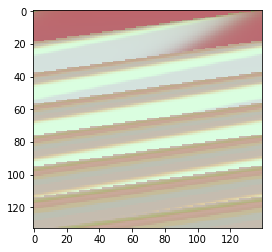

In [11]:
#Showing Flower Results
pyplot.imshow(X=np.array(Y2_pred).reshape(133,140,3)/np.amax(Y2_pred))
pyplot.show()